In [1]:
import igraph
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from supervisedRWfunc import *

Load the graph using igraph because it is faster and more lightweight. Depending on the algorithm, the graph must be a single connected component, which requires to extract the largest connected component of the graph first.

In [2]:
# Read the unweighted graph from an edgelist file
network = igraph.Graph.Read_Edgelist('test/banana,k=3.el', directed=True)
network_end = igraph.Graph.Read_Edgelist('test/banana,k=4.el', directed=True)

# Read the features of each vertex.
X = pd.read_table('test/banana,x.tab', header=None)

# vc = network.components()
# giant_component_ind = np.where(np.array(vc.membership) == np.argmax(vc.sizes()))[0]
# sg = network.induced_subgraph(giant_component_ind)

# nnodes = sg.vcount()
# edges = sg.get_edgelist()
# degree = sg.degree()

Draw the network to see how the features are related to each other on a two-dimensional space

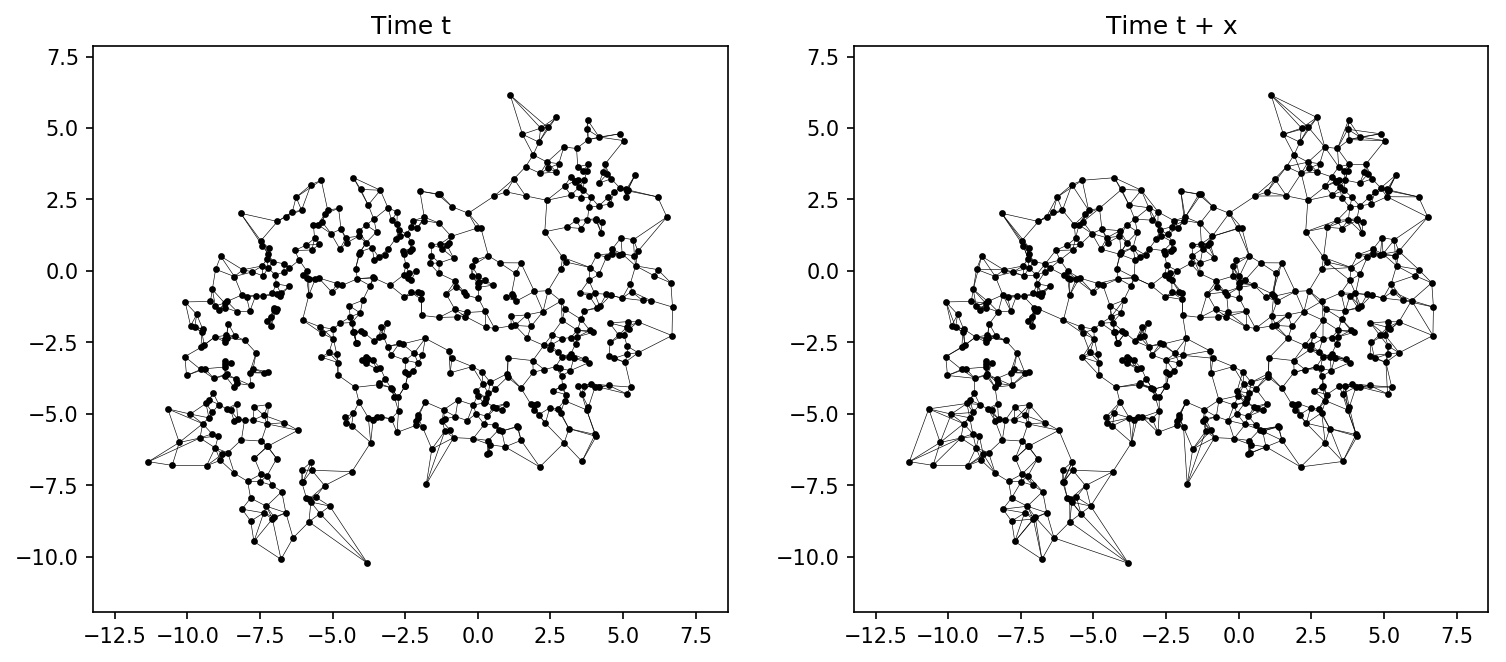

In [3]:
# layout maps the position of each vertex: {'0': [x_0, y_0], '1': [x_1, y_1], ...}
layout = dict([(str(k), v) for k, v in X.T.to_dict(orient='list').items()])

ng1 = nx.read_edgelist('test/banana,k=3.el')
ng2 = nx.read_edgelist('test/banana,k=4.el')

f, axarr = plt.subplots(1, 2, sharex=True, figsize=(12, 5), dpi=150)

axarr[0].set_title('Time t')
nx.draw_networkx_nodes(ng1, ax=axarr[0], pos=layout, node_size=5, node_color='black')
nx.draw_networkx_edges(ng1, ax=axarr[0], pos=layout, width=0.3);

axarr[1].set_title('Time t + x')
nx.draw_networkx_nodes(ng2, ax=axarr[1], pos=layout, node_size=5, node_color='black')
nx.draw_networkx_edges(ng2, ax=axarr[1], pos=layout, width=0.3);

# Preparing the training data

In [4]:
nnodes = network.vcount()
edges = network.get_edgelist()
degrees = network.degree()

nnodes_end = network_end .vcount()
edges_end  = network_end .get_edgelist()
degrees_end  = network_end .degree()

print('Vertices={}, Edges={}'.format(nnodes, len(edges)))

Vertices=600, Edges=1153


In [5]:
edge_feature = []
# features are formed with intercept term
for src, dst in edges:
    x1, x2 = (X[0][src] - X[0][dst])**2, (X[1][src] - X[1][src])**2
    edge_feature.append([x1, x2])

In [6]:
# compute the candidate set for future links according to source node
# train model with a set of source nodes
elig_source = []
for i in range(len(degrees)): 
    if degrees[i] > 0:
        elig_source.append(i)

# pick nodes with number of future links larger than theshold
# these nodes then served as either training node or test node
Dsize_cut = 3

D_source = []
Dset_all = []
Lset_all = []
for i in range(len(elig_source)):
    sNeighbor = []
    for e in edges:
        if e[0] == elig_source[i]:
            sNeighbor.append(e[1])
        elif e[1] == elig_source[i]:
            sNeighbor.append(e[0])
    candidates = list(set(list(range(nnodes))) - set([elig_source[i]]) - set(sNeighbor))
    
    sNeighbor_end = []
    for e in edges_end:
        if e[0] == elig_source[i]:
            sNeighbor_end.append(e[1])
        elif e[1] == elig_source[i]:
            sNeighbor_end.append(e[0])
    tempDset = list(set(sNeighbor_end) - set(sNeighbor))
    if len(tempDset) >= Dsize_cut:
        tempLset = list(set(candidates) - set(tempDset))
        Dset_all.append(tempDset)
        Lset_all.append(tempLset)
        D_source.append(elig_source[i])
        
print('D_source size is {}'.format(len(D_source)))

D_source size is 45


In [7]:
# randomly pick nodes with current degree > 0 and number of future 
# links >= Dsize_cut as the training set
trainSize = 35
testSize = 10
assert trainSize + testSize <= len(D_source)
                                   
# this index is the index of source nodes in D_source list
source_index = np.random.choice(list(range(len(D_source))), 
                                size=trainSize, replace=False)
source = []
Dset = []
Lset = []
for i in source_index:
    source.append(D_source[i])
    Dset.append(Dset_all[i])
    Lset.append(Lset_all[i])

# randomly pick nodes with current degree > 0, number of future links 
# >= Dsize_cut and haven't been picked as training nodes to be test nodes
test_index = np.random.choice(list(set(list(range(len(D_source)))) - 
                              set(source_index)), size=testSize, replace=False)

In [8]:
testSet = []
Dset_test = []
Lset_test = []
candidates_test = []

# original code
for i in test_index:
    testSet.append(D_source[i])
    Dset_test.append(Dset_all[i])
    Lset_test.append(Lset_all[i])
    candidates_test.append(Dset_all[i] + Lset_all[i])

In [9]:
print("Training model...")

# set up parameters
lam = 50
offset = 0.01
alpha = 0.3
beta_init = [2, 2]

#ff = genFeatures(nnodes, edges, edge_feature)
#trans_p = genTrans_plain(nnodes, edges, 0, 0)
#qqp = diffQ(ff, [0, 0.5, 0.5], trans_p, alpha)
#print qqp
beta_Opt = trainModel(Dset, Lset, offset, lam, nnodes, edges, edge_feature, 
                      source, alpha, beta_init)

# train model direclty wtth test set, compare performance with UWRW
#beta_Opt = trainModel(Dset_test, Lset_test, offset, lam, nnodes, edges, edge_feature, 
#                      testSet, alpha, beta_init)


Training model...


In [15]:
print("Training source set:\n", source)
print("\nTrained model parameters:\n", beta_Opt)

Training source set:
 [138, 183, 399, 165, 177, 546, 101, 238, 544, 6, 4, 427, 494, 93, 567, 577, 200, 23, 63, 201, 253, 224, 247, 596, 416, 15, 58, 397, 196, 525, 357, 403, 422, 457, 392]

Trained model parameters:
 (array([  2.05636457e-01,   5.43919308e-05]), 8324.2885181744696, {'grad': array([-0.00400529,  0.00543919]), 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 7, 'nit': 6, 'warnflag': 0})


# Compare

In [13]:
print("Evaluating model performance...")

# link prediction with transition matrices computed with trained parameters
ff = genFeatures(nnodes, edges, edge_feature)
trans_srw = genTrans(nnodes, edges, ff, testSet, alpha, beta_Opt[0])
#trans_srw = genTrans(nnodes, edges, ff, testSet, alpha, [10, 10])

# compute personalized PageRank for test nodes to recommend links
pgrank_srw = []
cand_pairs_srw = []
link_hits_srw = []
for i in range(len(testSet)):
    pp = np.repeat(1.0/nnodes, nnodes)
    curpgrank = iterPageRank(pp, trans_srw[i])
    # record the pgrank score
    pgrank_srw.append(curpgrank)
    
    # find the top ranking nodes in candidates set
    cand_pairs = []
    for j in candidates_test[i]:
        cand_pairs.append((j, curpgrank[j]))
    cand_pairs = sorted(cand_pairs, key = lambda x: x[1], reverse=True)
    # record candidate-pagerank pairs
    cand_pairs_srw.append(cand_pairs)
    
    # calculate precision of the top-Dsize_cut predicted links
    link_hits = 0    
    for j in range(Dsize_cut):
        if cand_pairs[j][0] in Dset_test[i]:
            link_hits += 1
    link_hits_srw.append(link_hits)

print("\nSRW performance: ", np.mean(link_hits_srw))


Evaluating model performance...

SRW performance:  1.8


In [16]:
# evaluate and compared the performance of unweighted random walk
print("Evaluating alternative models...")

# generate unweighted transition matrices for testSet nodes
trans_uw = genTrans_plain(nnodes, edges, testSet, alpha)

# compute personalized PageRank for test nodes to recommend links
pgrank_uw = []
cand_pairs_uw = []
link_hits_uw = []
for i in range(len(testSet)):
    pp = np.repeat(1.0 / nnodes, nnodes)
    curpgrank = iterPageRank(pp, trans_uw[i])
    # record the pgrank score
    pgrank_uw.append(curpgrank)
    
    # find the top ranking nodes in candidates set
    cand_pairs = []
    for j in candidates_test[i]:
        cand_pairs.append((j, curpgrank[j]))
    cand_pairs = sorted(cand_pairs, key = lambda x: x[1], reverse=True)
    # record candidate-pagerank pairs
    cand_pairs_uw.append(cand_pairs)
    
    # calculate precision of the top-Dsize_cut predicted links
    link_hits = 0    
    for j in range(Dsize_cut):
        if cand_pairs[j][0] in Dset_test[i]:
            link_hits += 1
    link_hits_uw.append(link_hits)

print("\nUW performance: ", np.mean(link_hits_uw))

Evaluating alternative models...

UW performance:  1.9
